In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import os

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

PyTorch Version: 2.6.0
CUDA Available: False
Using device: cpu


## Data Loading

In [3]:
import torch
import pandas as pd
import numpy as np
import os

# --- Configuration ---
DATA_DIR = 'data/'
X_TRAIN_PATH = os.path.join(DATA_DIR, 'x_train.csv')
Y_TRAIN_PATH = os.path.join(DATA_DIR, 'y_train.csv')
X_TEST_PATH = os.path.join(DATA_DIR, 'x_test.csv')
Y_TEST_PATH = os.path.join(DATA_DIR, 'y_test.csv')

EXPECTED_TRAIN_SAMPLES = 60000
EXPECTED_TEST_SAMPLES = 10000
EXPECTED_FEATURES = 784
EXPECTED_IMG_SHAPE_TENSOR = (1, 28, 28) # (C, H, W)
EXPECTED_LABEL_CLASSES = 5

print("--- 1. Loading Data ---")
try:
    x_train_df = pd.read_csv(X_TRAIN_PATH)
    y_train_df = pd.read_csv(Y_TRAIN_PATH)
    x_test_df = pd.read_csv(X_TEST_PATH)
    y_test_df = pd.read_csv(Y_TEST_PATH)
    print("CSV files loaded into Pandas DataFrames successfully.")
except Exception as e:
    print(f"Error loading CSV files: {e}")
    raise

print("\n--- 2. Inspecting DataFrames (Raw) ---")
print(f"x_train_df shape: {x_train_df.shape}")
print(f"y_train_df shape: {y_train_df.shape}")
print(f"x_test_df shape: {x_test_df.shape}")
print(f"y_test_df shape: {y_test_df.shape}")


print("\nx_train_df Head:")
print(x_train_df.head(3))
print("\ny_train_df Head:")
print(y_train_df.head(3))

label_col_name = y_train_df.columns[0]
print(f"\nValue Counts for column '{label_col_name}' in y_train_df:")
print(y_train_df[label_col_name].value_counts().sort_index())

# Check for NaN values
print(f"\nNaN values check:")
print(f"  x_train: {x_train_df.isnull().sum().sum()}")
print(f"  y_train: {y_train_df.isnull().sum().sum()}")
print(f"  x_test: {x_test_df.isnull().sum().sum()}")
print(f"  y_test: {y_test_df.isnull().sum().sum()}")

# Verify shapes match expectations (rows)
assert x_train_df.shape[0] == EXPECTED_TRAIN_SAMPLES, f"Unexpected number of rows in x_train_df"
assert y_train_df.shape[0] == EXPECTED_TRAIN_SAMPLES, f"Unexpected number of rows in y_train_df"
assert x_test_df.shape[0] == EXPECTED_TEST_SAMPLES, f"Unexpected number of rows in x_test_df"
assert y_test_df.shape[0] == EXPECTED_TEST_SAMPLES, f"Unexpected number of rows in y_test_df"
# Verify features/columns
assert x_train_df.shape[1] == EXPECTED_FEATURES, f"Unexpected number of columns in x_train_df"
assert x_test_df.shape[1] == EXPECTED_FEATURES, f"Unexpected number of columns in x_test_df"
assert y_train_df.shape[1] == 1, f"Unexpected number of columns in y_train_df"
assert y_test_df.shape[1] == 1, f"Unexpected number of columns in y_test_df"

print("\nDataFrame shapes and basic content look correct.")

print("\n--- 3. Converting, Reshaping, Normalizing ---")
x_train_np = x_train_df.values
y_train_np = y_train_df.values.squeeze()
x_test_np = x_test_df.values
y_test_np = y_test_df.values.squeeze()

x_train_tensor = torch.from_numpy(x_train_np).float()
y_train_tensor = torch.from_numpy(y_train_np).long()
x_test_tensor = torch.from_numpy(x_test_np).float()
y_test_tensor = torch.from_numpy(y_test_np).long()

# Reshape image data for CNNs
# (N, C, H, W)
x_train_tensor = x_train_tensor.reshape(-1, *EXPECTED_IMG_SHAPE_TENSOR) # (N, 1, 28, 28)
x_test_tensor = x_test_tensor.reshape(-1, *EXPECTED_IMG_SHAPE_TENSOR)  # (N, 1, 28, 28)

# Normalize pixel values
# Scale pixel values from [0, 255] to [0, 1]
x_train_tensor = x_train_tensor / 255.0
x_test_tensor = x_test_tensor / 255.0

print("Data converted to Tensors, reshaped, and normalized.")

print("\n--- 4. Verifying Processed Tensors ---")
assert x_train_tensor.shape == (EXPECTED_TRAIN_SAMPLES, *EXPECTED_IMG_SHAPE_TENSOR), \
    f"x_train_tensor shape mismatch: Expected {(EXPECTED_TRAIN_SAMPLES, *EXPECTED_IMG_SHAPE_TENSOR)}, Got {x_train_tensor.shape}"
assert y_train_tensor.shape == (EXPECTED_TRAIN_SAMPLES,), \
    f"y_train_tensor shape mismatch: Expected {(EXPECTED_TRAIN_SAMPLES,)}, Got {y_train_tensor.shape}"
assert x_test_tensor.shape == (EXPECTED_TEST_SAMPLES, *EXPECTED_IMG_SHAPE_TENSOR), \
    f"x_test_tensor shape mismatch: Expected {(EXPECTED_TEST_SAMPLES, *EXPECTED_IMG_SHAPE_TENSOR)}, Got {x_test_tensor.shape}"
assert y_test_tensor.shape == (EXPECTED_TEST_SAMPLES,), \
    f"y_test_tensor shape mismatch: Expected {(EXPECTED_TEST_SAMPLES,)}, Got {y_test_tensor.shape}"
print("Tensor shapes are correct.")

print("\n--- Data Loading and Preprocessing Complete ---")

--- 1. Loading Data ---
CSV files loaded into Pandas DataFrames successfully.

--- 2. Inspecting DataFrames (Raw) ---
x_train_df shape: (60000, 784)
y_train_df shape: (60000, 1)
x_test_df shape: (10000, 784)
y_test_df shape: (10000, 1)

x_train_df Head:
   0  1  2  3  4  5  6  7  8   9  ...  774  775  776  777  778  779  780  781  \
0  0  0  0  0  0  0  0  0  0   0  ...    0    0    0    0    0    0    0    0   
1  0  0  0  0  0  1  0  0  0   0  ...  119  114  130   76    0    0    0    0   
2  0  0  0  0  0  0  0  0  0  22  ...    0    0    1    0    0    0    0    0   

   782  783  
0    0    0  
1    0    0  
2    0    0  

[3 rows x 784 columns]

y_train_df Head:
   0
0  1
1  2
2  2

Value Counts for column '0' in y_train_df:
0
0     6000
1    12000
2    30000
3     6000
4     6000
Name: count, dtype: int64

NaN values check:
  x_train: 0
  y_train: 0
  x_test: 0
  y_test: 0

DataFrame shapes and basic content look correct.

--- 3. Converting, Reshaping, Normalizing ---
Data conve

Displaying random samples from the training set...


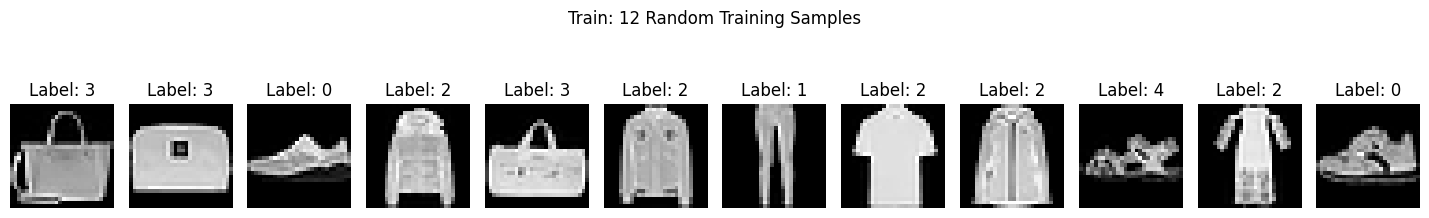

In [4]:
def show_images(dataset, labels, n_samples=10, title_prefix=""):
    """Displays n_samples random images from the dataset."""
    plt.figure(figsize=(n_samples * 1.2, 2.5)) # Adjust figure size based on number of samples
    indices = np.random.choice(len(dataset), n_samples, replace=False)
    for i, idx in enumerate(indices):
        img = dataset[idx]      # Shape (1, 28, 28)
        label = labels[idx].item() # Get scalar value from tensor

        img_display = img.squeeze().cpu().numpy()

        plt.subplot(1, n_samples, i + 1)
        plt.imshow(img_display, cmap='gray')
        plt.title(f"Label: {label}")
        plt.axis('off')
    plt.suptitle(f"{title_prefix}{n_samples} Random Training Samples", y=1.02)
    plt.tight_layout()
    plt.show()

print("Displaying random samples from the training set...")
show_images(x_train_tensor, y_train_tensor, n_samples=12, title_prefix="Train: ")

In [5]:
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split

# --- Hyperparameters for Data Loading ---
VALIDATION_SPLIT = 0.2 # Use 20% of the training data for validation
BATCH_SIZE = 64        # Batch size for training and evaluation


full_train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

print(f"Created TensorDatasets:")
print(f"  Full training set size: {len(full_train_dataset)}")
print(f"  Test set size: {len(test_dataset)}")


num_train_samples = len(full_train_dataset)
num_val_samples = int(VALIDATION_SPLIT * num_train_samples)
num_train_split = num_train_samples - num_val_samples

train_dataset, val_dataset = random_split(
    full_train_dataset,
    [num_train_split, num_val_samples],
    generator=torch.Generator().manual_seed(SEED)
)

print(f"\nSplit training data:")
print(f"  Training subset size: {len(train_dataset)}")
print(f"  Validation subset size: {len(val_dataset)}")


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"\nCreated DataLoaders:")
print(f"  Train loader: {len(train_loader)} batches of size {BATCH_SIZE}")
print(f"  Validation loader: {len(val_loader)} batches of size {BATCH_SIZE}")
print(f"  Test loader: {len(test_loader)} batches of size {BATCH_SIZE}")


Created TensorDatasets:
  Full training set size: 60000
  Test set size: 10000

Split training data:
  Training subset size: 48000
  Validation subset size: 12000

Created DataLoaders:
  Train loader: 750 batches of size 64
  Validation loader: 188 batches of size 64
  Test loader: 157 batches of size 64


## Helper Functions

In [6]:
# Training and Evaluation Functions

import time

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    """Trains the model for one epoch."""
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    start_time = time.time()
    for i, (inputs, labels) in enumerate(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward Pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward Pass and Optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted_labels = torch.max(outputs, 1)
        correct_predictions += (predicted_labels == labels).sum().item()
        total_samples += labels.size(0)

    epoch_time = time.time() - start_time
    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples

    return epoch_loss, epoch_acc, epoch_time


def evaluate(model, dataloader, criterion, device):
    """Evaluates the model on a given dataset."""
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    start_time = time.time()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward Pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted_labels = torch.max(outputs, 1)
            correct_predictions += (predicted_labels == labels).sum().item()
            total_samples += labels.size(0)

    eval_time = time.time() - start_time
    eval_loss = running_loss / total_samples
    eval_acc = correct_predictions / total_samples

    return eval_loss, eval_acc, eval_time


## Q1 - Default Architecture

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class DefaultCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(DefaultCNN, self).__init__()
        # Layer 1: Conv -> ReLU -> MaxPool
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        # Input: (N, 1, 28, 28)
        # Conv1 Output: (N, 32, 28, 28) (Padding keeps size same: 28 - 3 + 2*1 + 1 = 28)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Pool1 Output: (N, 32, 14, 14) (28 / 2 = 14)

        # Layer 2: Conv -> ReLU
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        # Input: (N, 32, 14, 14)
        # Conv2 Output: (N, 32, 14, 14) (Padding keeps size same: 14 - 3 + 2*1 + 1 = 14)

        # Dense Layers
        # Output of conv2 is (N, 32, 14, 14)
        self.flattened_size = 32 * 14 * 14
        self.fc1 = nn.Linear(self.flattened_size, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # Layer 1
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)

        # Layer 2
        x = self.conv2(x)
        x = F.relu(x)

        x = x.view(x.size(0), -1)

        # Dense Layers
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        return x

q1_model = DefaultCNN(num_classes=EXPECTED_LABEL_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer_q1 = optim.SGD(q1_model.parameters(), lr=0.01, momentum=0.9)

print("--- Q1 Default CNN Architecture ---")
print(q1_model)

# try:
#     from torchsummary import summary
#     # Provide the input shape (C, H, W) excluding the batch dimension
#     summary(q1_model, input_size=EXPECTED_IMG_SHAPE_TENSOR, device=device.type)
# except ImportError:
#     print("\n'torchsummary' not found. Skipping detailed summary.")
#     print(f"Model has {sum(p.numel() for p in q1_model.parameters() if p.requires_grad):,} trainable parameters.")

--- Q1 Default CNN Architecture ---
DefaultCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=6272, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=5, bias=True)
)


In [8]:
# Training Hyperparameters
NUM_EPOCHS_Q1 = 15
MODEL_NAME_Q1 = "DefaultCNN_Q1"

print(f"--- Training {MODEL_NAME_Q1} for {NUM_EPOCHS_Q1} epochs ---")
print(f"Device: {device}")
print(f"Optimizer: {type(optimizer_q1).__name__} (LR={optimizer_q1.defaults['lr']})")
print(f"Batch size: {BATCH_SIZE}")
print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")

# --- History Tracking ---
history_q1 = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'epoch_time': []
}

total_train_start_time = time.time()

for epoch in range(NUM_EPOCHS_Q1):
    train_loss, train_acc, train_time = train_one_epoch(
        q1_model, train_loader, criterion, optimizer_q1, device
    )

    val_loss, val_acc, val_time = evaluate(
        q1_model, val_loader, criterion, device
    )

    # Record history
    history_q1['train_loss'].append(train_loss)
    history_q1['train_acc'].append(train_acc)
    history_q1['val_loss'].append(val_loss)
    history_q1['val_acc'].append(val_acc)
    history_q1['epoch_time'].append(train_time + val_time)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS_Q1} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} ({train_time:.2f}s) | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} ({val_time:.2f}s)")

total_train_end_time = time.time()
total_training_time_q1 = total_train_end_time - total_train_start_time
avg_epoch_time_q1 = sum(history_q1['epoch_time']) / NUM_EPOCHS_Q1

print(f"\n--- Training Finished ---")
print(f"Total Training Time ({MODEL_NAME_Q1}): {total_training_time_q1:.2f}s")
print(f"Average Epoch Time ({MODEL_NAME_Q1}): {avg_epoch_time_q1:.2f}s")

# --- Evaluate Final Model on Test Set ---
print(f"\n--- Evaluating {MODEL_NAME_Q1} on Test Set ---")
test_loss_q1, test_acc_q1, test_time_q1 = evaluate(
    q1_model, test_loader, criterion, device
)
print(f"Test Loss ({MODEL_NAME_Q1}): {test_loss_q1:.4f}")
print(f"Test Accuracy ({MODEL_NAME_Q1}): {test_acc_q1:.4f}")
print(f"Test Evaluation Time ({MODEL_NAME_Q1}): {test_time_q1:.2f}s")

# Store test results
history_q1['test_loss'] = test_loss_q1
history_q1['test_acc'] = test_acc_q1
history_q1['test_time'] = test_time_q1
history_q1['total_train_time'] = total_training_time_q1

--- Training DefaultCNN_Q1 for 15 epochs ---
Device: cpu
Optimizer: SGD (LR=0.01)
Batch size: 64
Train samples: 48000, Val samples: 12000
Epoch 1/15 | Train Loss: 0.2249, Train Acc: 0.9221 (16.14s) | Val Loss: 0.1146, Val Acc: 0.9634 (1.95s)
Epoch 2/15 | Train Loss: 0.0918, Train Acc: 0.9717 (14.02s) | Val Loss: 0.0851, Val Acc: 0.9733 (1.97s)
Epoch 3/15 | Train Loss: 0.0725, Train Acc: 0.9769 (15.30s) | Val Loss: 0.0745, Val Acc: 0.9754 (2.28s)
Epoch 4/15 | Train Loss: 0.0609, Train Acc: 0.9799 (15.21s) | Val Loss: 0.0635, Val Acc: 0.9785 (2.48s)
Epoch 5/15 | Train Loss: 0.0524, Train Acc: 0.9825 (18.49s) | Val Loss: 0.0636, Val Acc: 0.9772 (2.71s)
Epoch 6/15 | Train Loss: 0.0453, Train Acc: 0.9848 (16.66s) | Val Loss: 0.0688, Val Acc: 0.9758 (2.08s)
Epoch 7/15 | Train Loss: 0.0410, Train Acc: 0.9860 (15.74s) | Val Loss: 0.0559, Val Acc: 0.9808 (4.96s)
Epoch 8/15 | Train Loss: 0.0363, Train Acc: 0.9877 (18.25s) | Val Loss: 0.0633, Val Acc: 0.9794 (2.24s)
Epoch 9/15 | Train Loss: 0.031

## Q2 - Improved Architecture

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class ImprovedCNN(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.5):
        super(ImprovedCNN, self).__init__()
        # Layer 1: Conv -> BN -> ReLU -> MaxPool
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Input: (N, 1, 28, 28) -> Conv1: (N, 32, 28, 28) -> BN1 -> ReLU -> Pool1: (N, 32, 14, 14)

        # Layer 2: Conv -> BN -> ReLU -> MaxPool
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64) # Batch Norm after Conv2
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Input: (N, 32, 14, 14) -> Conv2: (N, 64, 14, 14) -> BN2 -> ReLU -> Pool2: (N, 64, 7, 7)

        self.flattened_size = 64 * 7 * 7

        # Dense Layers
        self.fc1 = nn.Linear(self.flattened_size, 512)
        self.bn3 = nn.BatchNorm1d(512)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # Layer 
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)

        # Layer 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = x.view(x.size(0), -1)

        # Dense Layers
        x = self.fc1(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x


q2_model = ImprovedCNN(num_classes=EXPECTED_LABEL_CLASSES, dropout_rate=0.5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer_q2 = optim.Adam(q2_model.parameters(), lr=0.001) # Using Adam optimizer

print("--- Q2 Improved CNN Architecture ---")
print(q2_model)


# try:
#     from torchsummary import summary
#     summary(q2_model, input_size=EXPECTED_IMG_SHAPE_TENSOR, device=device.type)
# except ImportError:
#     print("\n'torchsummary' not found. Skipping detailed summary.")
#     print(f"Model has {sum(p.numel() for p in q2_model.parameters() if p.requires_grad):,} trainable parameters.")

--- Q2 Improved CNN Architecture ---
ImprovedCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=512, bias=True)
  (bn3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=5, bias=True)
)


In [10]:
# Training Hyperparameters
NUM_EPOCHS_Q2 = 15
MODEL_NAME_Q2 = "ImprovedCNN_Q2"

print(f"--- Training {MODEL_NAME_Q2} for {NUM_EPOCHS_Q2} epochs ---")
print(f"Device: {device}")
print(f"Optimizer: {type(optimizer_q2).__name__} (LR={optimizer_q2.defaults['lr']})")
print(f"Batch size: {BATCH_SIZE}")
print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")
print(f"Dropout rate: {q2_model.dropout.p}")

# History Tracking  
history_q2 = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'epoch_time': []
}

total_train_start_time = time.time()

for epoch in range(NUM_EPOCHS_Q2):
    train_loss, train_acc, train_time = train_one_epoch(
        q2_model, train_loader, criterion, optimizer_q2, device
    )

    val_loss, val_acc, val_time = evaluate(
        q2_model, val_loader, criterion, device
    )

    # Record history
    history_q2['train_loss'].append(train_loss)
    history_q2['train_acc'].append(train_acc)
    history_q2['val_loss'].append(val_loss)
    history_q2['val_acc'].append(val_acc)
    history_q2['epoch_time'].append(train_time + val_time)


    print(f"Epoch {epoch+1}/{NUM_EPOCHS_Q2} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} ({train_time:.2f}s) | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} ({val_time:.2f}s)")

total_train_end_time = time.time()
total_training_time_q2 = total_train_end_time - total_train_start_time
avg_epoch_time_q2 = sum(history_q2['epoch_time']) / NUM_EPOCHS_Q2 if NUM_EPOCHS_Q2 > 0 else 0

print(f"\n--- Training Finished ---")
print(f"Total Training Time ({MODEL_NAME_Q2}): {total_training_time_q2:.2f}s")
print(f"Average Epoch Time ({MODEL_NAME_Q2}): {avg_epoch_time_q2:.2f}s")

# Evaluate Final Model on Test Set
print(f"\n--- Evaluating {MODEL_NAME_Q2} on Test Set ---")
test_loss_q2, test_acc_q2, test_time_q2 = evaluate(
    q2_model, test_loader, criterion, device
)
print(f"Test Loss ({MODEL_NAME_Q2}): {test_loss_q2:.4f}")
print(f"Test Accuracy ({MODEL_NAME_Q2}): {test_acc_q2:.4f}")
print(f"Test Evaluation Time ({MODEL_NAME_Q2}): {test_time_q2:.2f}s")

# Store test results
history_q2['test_loss'] = test_loss_q2
history_q2['test_acc'] = test_acc_q2
history_q2['test_time'] = test_time_q2
history_q2['total_train_time'] = total_training_time_q2

--- Training ImprovedCNN_Q2 for 15 epochs ---
Device: cpu
Optimizer: Adam (LR=0.001)
Batch size: 64
Train samples: 48000, Val samples: 12000
Dropout rate: 0.5
Epoch 1/15 | Train Loss: 0.0969, Train Acc: 0.9685 (16.16s) | Val Loss: 0.0686, Val Acc: 0.9772 (2.22s)
Epoch 2/15 | Train Loss: 0.0541, Train Acc: 0.9820 (15.95s) | Val Loss: 0.0479, Val Acc: 0.9823 (2.27s)
Epoch 3/15 | Train Loss: 0.0420, Train Acc: 0.9846 (17.39s) | Val Loss: 0.0405, Val Acc: 0.9862 (2.26s)
Epoch 4/15 | Train Loss: 0.0331, Train Acc: 0.9889 (15.85s) | Val Loss: 0.0395, Val Acc: 0.9863 (2.16s)
Epoch 5/15 | Train Loss: 0.0270, Train Acc: 0.9909 (15.51s) | Val Loss: 0.0400, Val Acc: 0.9864 (2.14s)
Epoch 6/15 | Train Loss: 0.0248, Train Acc: 0.9915 (16.61s) | Val Loss: 0.0446, Val Acc: 0.9855 (2.33s)
Epoch 7/15 | Train Loss: 0.0217, Train Acc: 0.9919 (15.81s) | Val Loss: 0.0434, Val Acc: 0.9854 (2.17s)
Epoch 8/15 | Train Loss: 0.0181, Train Acc: 0.9935 (16.10s) | Val Loss: 0.0367, Val Acc: 0.9886 (2.30s)
Epoch 9/1

Defined data augmentation transforms.
Train transforms: Compose(
    ToPILImage()
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
)

Successfully retrieved transformed sample:
  Image shape: torch.Size([1, 28, 28]), dtype: torch.float32, range: [0.00, 1.00]
  Label: 1


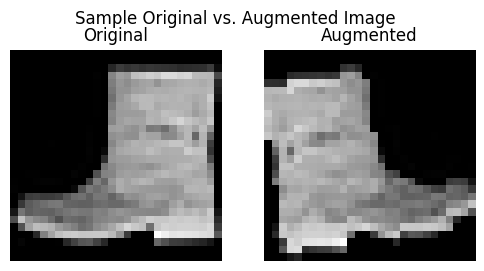

In [31]:
import torchvision.transforms as transforms
from torch.utils.data import Dataset

# --- 1. Define Augmentation Transforms ---
# Apply these only to the training data
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
])

# No augmentation for validation/test data, just ensure it's a tensor
identity_transform = transforms.Compose([
    # We already have tensors in [0,1] range, so this might not be strictly needed
    # but ensures consistency if we decide to add normalization later.
    # transforms.ToPILImage(), # If input wasn't already tensor
    # transforms.ToTensor()  # If input wasn't already tensor
])


# --- 2. Create a Wrapper Dataset to Apply Transforms ---
class TransformedDataset(Dataset):
    """A dataset wrapper that applies specified transforms to the data."""
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index] # Get the original tensor data and label
        if self.transform:
            # Apply transform. Ensure input to transform is suitable (e.g., PIL Image or Tensor)
            # Our train_transforms expects PIL, so we convert x (C, H, W)
            # Note: ToPILImage expects (C, H, W) or (H, W), ToTensor outputs (C, H, W)
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

# --- 3. Create new Transformed Datasets ---
# Apply augmentation transforms ONLY to the training subset
# The train_dataset and val_dataset below come from the random_split earlier
transformed_train_dataset = TransformedDataset(train_dataset, transform=train_transforms)

# Validation and test sets use the original data (no augmentation)
# We can wrap them too, even with an identity transform, if we want consistency
# or just use the original val_dataset and test_dataset directly in the DataLoaders.
# Let's stick to using the original ones for simplicity unless needed otherwise.

print("Defined data augmentation transforms.")
print(f"Train transforms: {train_transforms}")
# Check if a sample can be retrieved and transformed
try:
    sample_img, sample_label = transformed_train_dataset[0]
    print(f"\nSuccessfully retrieved transformed sample:")
    print(f"  Image shape: {sample_img.shape}, dtype: {sample_img.dtype}, range: [{sample_img.min():.2f}, {sample_img.max():.2f}]")
    print(f"  Label: {sample_label}")

    # Visualize original vs augmented
    original_img, _ = train_dataset[0]
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img.squeeze().cpu().numpy(), cmap='gray')
    plt.title("Original")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(sample_img.squeeze().cpu().numpy(), cmap='gray')
    plt.title("Augmented")
    plt.axis('off')
    plt.suptitle("Sample Original vs. Augmented Image")
    plt.show()

except Exception as e:
    print(f"\nError testing transformed dataset: {e}")

In [33]:
# Use the transformed dataset for training, original for validation/test
train_loader_q2_aug = DataLoader(transformed_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
# Validation and Test loaders remain the same as before (using original data)
# val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
# test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("--- Preparing for Augmented Data Model Training ---")
print(f"Using Data Augmentation for Training Loader: {train_transforms}")
print(f"Validation/Test Loaders use original data.")
print(f"Train loader: {len(train_loader_q2_aug)} batches")
print(f"Validation loader: {len(val_loader)} batches")
print(f"Test loader: {len(test_loader)} batches")

# Instantiate Model Experiment 3
# Using the same architecture as Q2
q2_aug_model = ImprovedCNN(num_classes=EXPECTED_LABEL_CLASSES, dropout_rate=0.5).to(device)
MODEL_NAME_Q2_AUG = "ImprovedCNN_Q2_Aug_WD"

# Define Optimizer 3 with Weight Decay
WEIGHT_DECAY = 1e-4 # Common value for weight decay
optimizer_q2_aug = optim.Adam(q2_aug_model.parameters(), lr=0.001, weight_decay=WEIGHT_DECAY)
# Criterion remains the same
criterion = nn.CrossEntropyLoss()

print(f"\nModel Architecture: {MODEL_NAME_Q2_AUG} (same as Q2)")
print(f"Optimizer: {type(optimizer_q2_aug).__name__} (LR={optimizer_q2_aug.defaults['lr']}, Weight Decay={WEIGHT_DECAY})")

# --- 4. Training Loop for Q2 Augmented ---
NUM_EPOCHS_Q2_AUG = 15

print(f"\n--- Training {MODEL_NAME_Q2_AUG} for {NUM_EPOCHS_Q2_AUG} epochs ---")

history_q2_aug = {
    'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'epoch_time': []
}
total_train_start_time = time.time()

for epoch in range(NUM_EPOCHS_Q2_AUG):
    # Use train_loader_q3 which has augmented data
    train_loss, train_acc, train_time = train_one_epoch(
        q2_aug_model, train_loader_q2_aug, criterion, optimizer_q2_aug, device
    )
    # Evaluate on the original validation data
    val_loss, val_acc, val_time = evaluate(
        q2_aug_model, val_loader, criterion, device
    )

    history_q2_aug['train_loss'].append(train_loss)
    history_q2_aug['train_acc'].append(train_acc)
    history_q2_aug['val_loss'].append(val_loss)
    history_q2_aug['val_acc'].append(val_acc)
    history_q2_aug['epoch_time'].append(train_time + val_time)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS_Q2_AUG} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} ({train_time:.2f}s) | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} ({val_time:.2f}s)")

total_train_end_time = time.time()
total_training_time_q2_aug = total_train_end_time - total_train_start_time
avg_epoch_time_q2_aug = sum(history_q2_aug['epoch_time']) / NUM_EPOCHS_Q2_AUG if NUM_EPOCHS_Q2_AUG > 0 else 0

print(f"\n--- Training Finished ({MODEL_NAME_Q2_AUG}) ---")
print(f"Total Training Time: {total_training_time_q2_aug:.2f}s")
print(f"Average Epoch Time: {avg_epoch_time_q2_aug:.2f}s")

# --- Evaluate Final Model on Test Set ---
print(f"\n--- Evaluating {MODEL_NAME_Q2_AUG} on Test Set ---")
# Evaluate on the original test data
test_loss_q2_aug, test_acc_q2_aug, test_time_q2_aug = evaluate(
    q2_aug_model, test_loader, criterion, device
)
print(f"Test Loss: {test_loss_q2_aug:.4f}")
print(f"Test Accuracy: {test_acc_q2_aug:.4f}")
print(f"Test Evaluation Time: {test_time_q2_aug:.2f}s")

# Store test results
history_q2_aug['test_loss'] = test_loss_q2_aug
history_q2_aug['test_acc'] = test_acc_q2_aug
history_q2_aug['test_time'] = test_time_q2_aug
history_q2_aug['total_train_time'] = total_training_time_q2_aug

--- Preparing for Augmented Data Model Training ---
Using Data Augmentation for Training Loader: Compose(
    ToPILImage()
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
)
Validation/Test Loaders use original data.
Train loader: 750 batches
Validation loader: 188 batches
Test loader: 157 batches

Model Architecture: ImprovedCNN_Q2_Aug_WD (same as Q2)
Optimizer: Adam (LR=0.001, Weight Decay=0.0001)

--- Training ImprovedCNN_Q2_Aug_WD for 15 epochs ---
Epoch 1/15 | Train Loss: 0.1364, Train Acc: 0.9542 (18.74s) | Val Loss: 0.0919, Val Acc: 0.9701 (2.12s)
Epoch 2/15 | Train Loss: 0.0872, Train Acc: 0.9706 (19.71s) | Val Loss: 0.0696, Val Acc: 0.9779 (2.17s)
Epoch 3/15 | Train Loss: 0.0747, Train Acc: 0.9748 (18.81s) | Val Loss: 0.0686, Val Acc: 0.9762 (2.30s)
Epoch 4/15 | Train Loss: 0.0699, Train Acc: 0.9772 (18.21s) | Val Loss: 0.0523, Val Acc: 0.9818 (2.26s)
Epoch 5/15 | Train Loss: 0.0670, Train Acc

## Validation Accuracy over Epochs

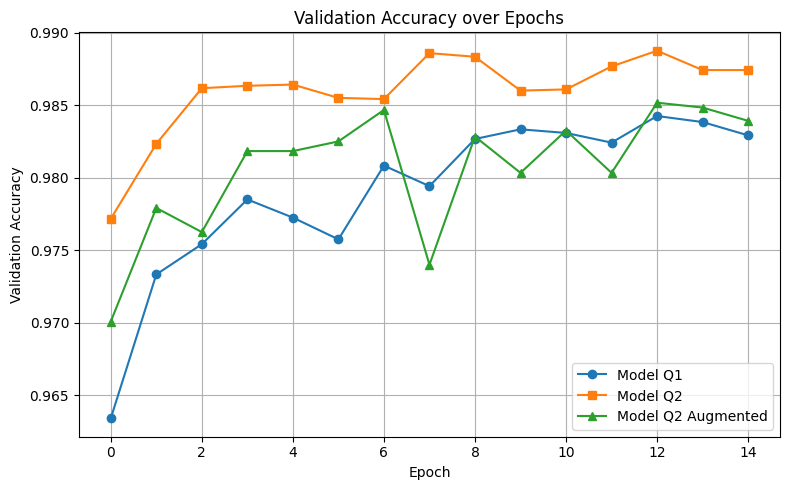

In [34]:
plt.figure(figsize=(8, 5))
plt.plot(history_q1['val_acc'], label='Model Q1', marker='o')
plt.plot(history_q2['val_acc'], label='Model Q2', marker='s')
plt.plot(history_q2_aug['val_acc'], label='Model Q2 Augmented', marker='^')

plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [38]:
results = {
    "Model": [MODEL_NAME_Q1, MODEL_NAME_Q2, MODEL_NAME_Q2_AUG],
    "Test Accuracy": [history_q1['test_acc'], history_q2['test_acc'], history_q2_aug['test_acc']],
    "Test Loss": [history_q1['test_loss'], history_q2['test_loss'], history_q2_aug['test_loss']],
    "Total Train Time (s)": [history_q1['total_train_time'], history_q2['total_train_time'], history_q2_aug['total_train_time']],
    "Avg Epoch Time (s)": [
        history_q1['total_train_time'] / NUM_EPOCHS_Q1 if NUM_EPOCHS_Q1 > 0 else 0,
        history_q2['total_train_time'] / NUM_EPOCHS_Q2 if NUM_EPOCHS_Q2 > 0 else 0,
        history_q2_aug['total_train_time'] / NUM_EPOCHS_Q2_AUG if NUM_EPOCHS_Q2_AUG > 0 else 0
    ],
     "Test Eval Time (s)": [history_q1['test_time'], history_q2['test_time'], history_q2_aug['test_time']],
}

results_df = pd.DataFrame(results)

results_df['Test Accuracy'] = results_df['Test Accuracy'].map('{:.4f}'.format)
results_df['Test Loss'] = results_df['Test Loss'].map('{:.4f}'.format)
results_df['Total Train Time (s)'] = results_df['Total Train Time (s)'].map('{:.2f}'.format)
results_df['Avg Epoch Time (s)'] = results_df['Avg Epoch Time (s)'].map('{:.2f}'.format)
results_df['Test Eval Time (s)'] = results_df['Test Eval Time (s)'].map('{:.2f}'.format)

print("--- Model Performance Summary ---")
print(results_df)

print("\n--- Design Comparison ---")
print(f"Q1 ({MODEL_NAME_Q1}): Basic CNN (2 Conv, 1 Pool, 1 Dense), SGD Optimizer")
print(f"Q2 ({MODEL_NAME_Q2}): Deeper CNN (2 Conv, 2 Pool), BatchNorm, Dropout, Adam Optimizer")
print(f"Q2 Augmented ({MODEL_NAME_Q2_AUG}): Same as Q2 + Training Data Augmentation + Weight Decay (L2 Regularization)")

--- Model Performance Summary ---
                   Model Test Accuracy Test Loss Total Train Time (s)  \
0          DefaultCNN_Q1        0.9845    0.0549               262.00   
1         ImprovedCNN_Q2        0.9887    0.0507               306.94   
2  ImprovedCNN_Q2_Aug_WD        0.9845    0.0468               321.95   

  Avg Epoch Time (s) Test Eval Time (s)  
0              17.47               1.83  
1              20.46               2.03  
2              21.46               2.12  

--- Design Comparison ---
Q1 (DefaultCNN_Q1): Basic CNN (2 Conv, 1 Pool, 1 Dense), SGD Optimizer
Q2 (ImprovedCNN_Q2): Deeper CNN (2 Conv, 2 Pool), BatchNorm, Dropout, Adam Optimizer
Q2 Augmented (ImprovedCNN_Q2_Aug_WD): Same as Q2 + Training Data Augmentation + Weight Decay (L2 Regularization)



--- Generating Performance Plots ---


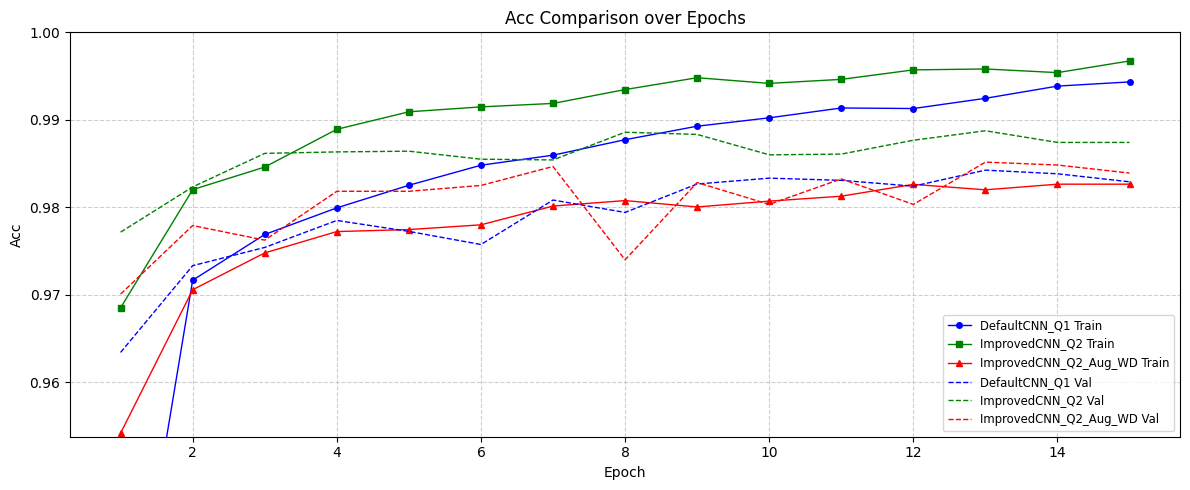

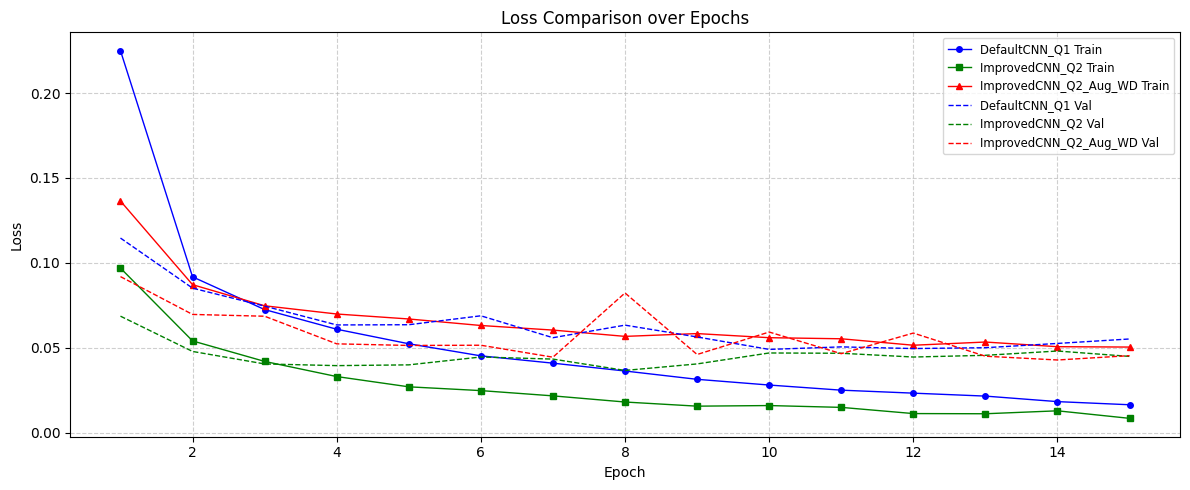

In [39]:
import matplotlib.pyplot as plt

def plot_metric_comparison(metric_name, history1, history2, history3, label1, label2, label3):
    """Plots Train vs Validation for a given metric across three models."""
    epochs = range(1, len(history1[f'train_{metric_name}']) + 1)
    plt.figure(figsize=(12, 5))

    # Plot Training Metrics
    plt.plot(epochs, history1[f'train_{metric_name}'], 'bo-', label=f'{label1} Train', markersize=4, linewidth=1)
    plt.plot(epochs, history2[f'train_{metric_name}'], 'gs-', label=f'{label2} Train', markersize=4, linewidth=1)
    plt.plot(epochs, history3[f'train_{metric_name}'], 'r^-', label=f'{label3} Train', markersize=4, linewidth=1)

    # Plot Validation Metrics
    plt.plot(epochs, history1[f'val_{metric_name}'], 'b--', label=f'{label1} Val', markersize=4, linewidth=1)
    plt.plot(epochs, history2[f'val_{metric_name}'], 'g--', label=f'{label2} Val', markersize=4, linewidth=1)
    plt.plot(epochs, history3[f'val_{metric_name}'], 'r--', label=f'{label3} Val', markersize=4, linewidth=1)

    # Formatting
    metric_title = metric_name.replace('_', ' ').title()
    plt.title(f'{metric_title} Comparison over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel(metric_title)
    # Adjust y-limits for accuracy
    if 'acc' in metric_name:
        min_val = min(min(history1[f'val_{metric_name}']), min(history2[f'val_{metric_name}']), min(history3[f'val_{metric_name}']))
        plt.ylim(max(0.9, min_val * 0.99), 1.0) # Start y-axis near the action for accuracy
    plt.legend(loc='best', fontsize='small')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

print("\n--- Generating Performance Plots ---")

# Plot Accuracy
plot_metric_comparison(
    'acc',
    history_q1, history_q2, history_q2_aug,
    MODEL_NAME_Q1, MODEL_NAME_Q2, MODEL_NAME_Q2_AUG
)

# Plot Loss
plot_metric_comparison(
    'loss',
    history_q1, history_q2, history_q2_aug,
    MODEL_NAME_Q1, MODEL_NAME_Q2, MODEL_NAME_Q2_AUG
)

--- Showing predictions for model: ImprovedCNN_Q2 ---


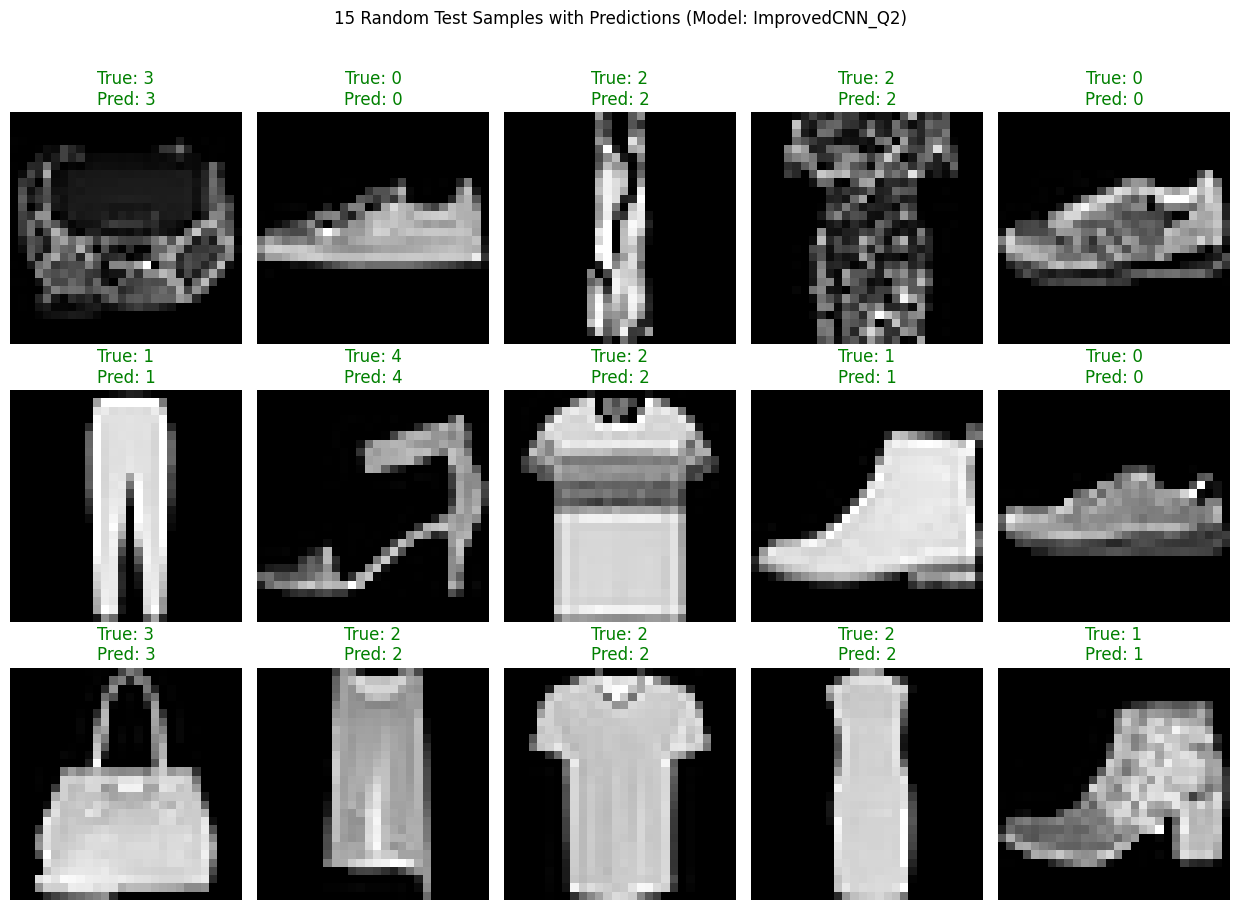

In [46]:
def show_predictions(model, dataset, device, n_samples=15):
    model.eval()
    indices = np.random.choice(len(dataset), n_samples, replace=False)

    cols = 5
    rows = int(np.ceil(n_samples / cols))
    plt.figure(figsize=(cols * 2.5, rows * 3))

    with torch.no_grad():
        for i, idx in enumerate(indices):
            image_tensor, true_label_tensor = dataset[idx]
            true_label = true_label_tensor.item() # Get scalar value
            image_batch = image_tensor.unsqueeze(0).to(device)
            outputs = model(image_batch)
            probabilities = torch.softmax(outputs, dim=1)
            predicted_label_tensor = torch.argmax(probabilities, dim=1)
            predicted_label = predicted_label_tensor.item()
            img_display = image_tensor.squeeze().cpu().numpy()
            plt.subplot(rows, cols, i + 1)
            plt.imshow(img_display, cmap='gray')
            title_color = 'green' if predicted_label == true_label else 'red'
            plt.title(f"True: {true_label}\nPred: {predicted_label}", color=title_color)
            plt.axis('off')

    plt.suptitle(f"{n_samples} Random Test Samples with Predictions (Model: {MODEL_NAME_Q2})", y=1.02) # Adjust y for suptitle spacing
    plt.tight_layout(rect=[0, 0, 1, 1]) # Adjust layout to prevent title overlap
    plt.show()

print(f"--- Showing predictions for model: {MODEL_NAME_Q2} ---")
show_predictions(q2_model, test_dataset, device, n_samples=15)

## CNN Feature Extractor (size 512 Dense Layer)

In [47]:
class FeatureExtractor(nn.Module):
    def __init__(self, original_model):
        super(FeatureExtractor, self).__init__()
        self.features = nn.Sequential(
            original_model.conv1,
            original_model.bn1,
            nn.ReLU(),
            original_model.pool1,
            original_model.conv2,
            original_model.bn2,
            nn.ReLU(),
            original_model.pool2
        )
        self.flatten = nn.Flatten()
        self.fc1 = original_model.fc1
        self.bn3 = original_model.bn3
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.bn3(x)
        x = self.relu(x)
        return x  # Return 512-dim encoded features

# Move model to the same device
feature_model = FeatureExtractor(q2_model).to(device)
feature_model.eval()

# Collect features
all_features = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        features = feature_model(inputs)
        all_features.append(features.cpu())
        all_labels.append(labels.cpu())

# Concatenate all features and labels
all_features_tensor = torch.cat(all_features, dim=0)
all_labels_tensor = torch.cat(all_labels, dim=0)

# Convert to pandas DataFrame
features_df = pd.DataFrame(all_features_tensor.numpy())
features_df['label'] = all_labels_tensor.numpy()  # Add labels as a column

print("Feature extraction complete.")
print(features_df.shape)

Feature extraction complete.
(12000, 513)


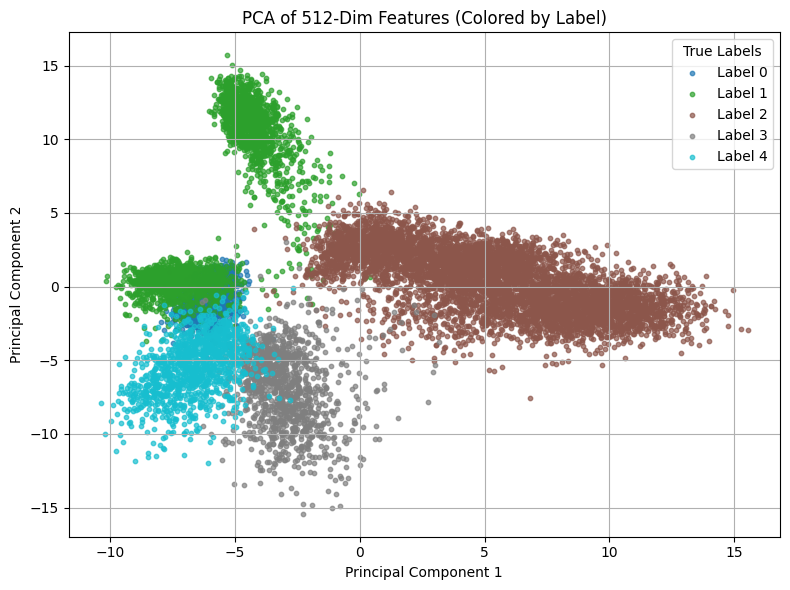

In [48]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# Extract features and labels
X = features_df.drop(columns=["label"]).values
y = features_df["label"].values
unique_labels = np.unique(y)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot
plt.figure(figsize=(8, 6))
for i, label in enumerate(unique_labels):
    idx = y == label
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], 
                color=colors[i], label=f"Label {label}", alpha=0.7, s=10)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA of 512-Dim Features (Colored by Label)")
plt.legend(title="True Labels", loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

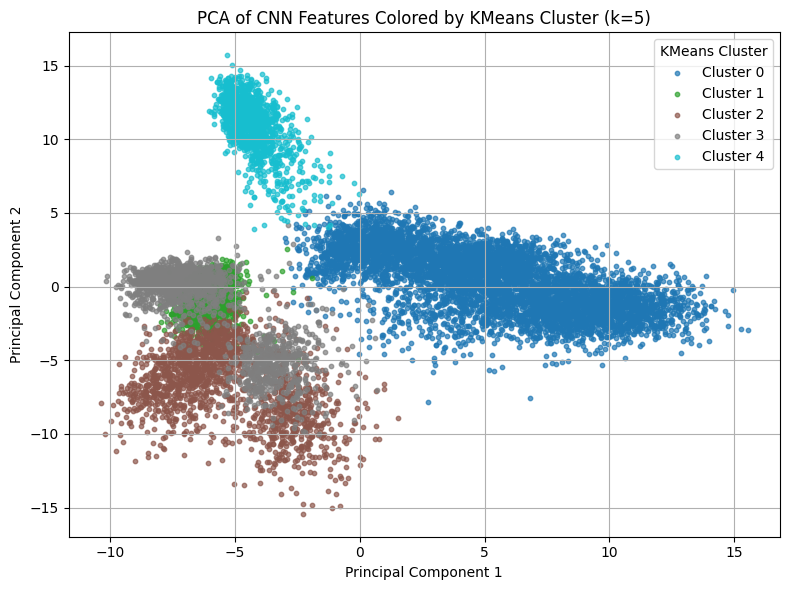

In [49]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Step 1: Prepare feature matrix and labels
X = features_df.drop(columns=["label"]).values

# Step 2: Run KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(X)

# Step 3: Reduce to 2D with PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Step 4: Plot with discrete legend
unique_clusters = np.unique(cluster_labels)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))

plt.figure(figsize=(8, 6))
for i, cluster in enumerate(unique_clusters):
    idx = cluster_labels == cluster
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1],
                color=colors[i], label=f"Cluster {cluster}", alpha=0.7, s=10)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA of CNN Features Colored by KMeans Cluster (k=5)")
plt.legend(title="KMeans Cluster", loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()


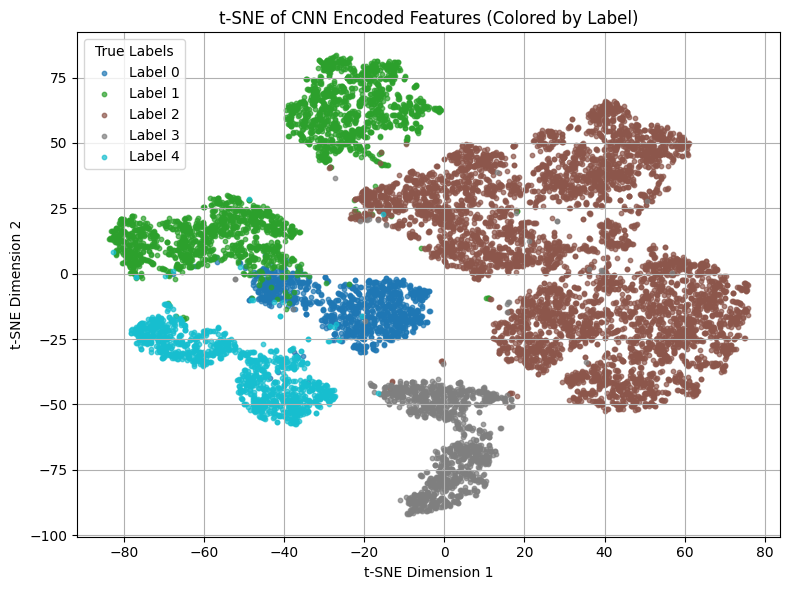

In [50]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from matplotlib.lines import Line2D
import numpy as np

# Get feature vectors (X) and labels (y)
X = features_df.drop(columns=["label"]).values
y = features_df["label"].values

# Run t-SNE to reduce 512-dim to 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
X_tsne = tsne.fit_transform(X)

# Set up a colormap and discrete label names
unique_labels = np.unique(y)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))

# Plot points by label
plt.figure(figsize=(8, 6))
for i, label in enumerate(unique_labels):
    indices = y == label
    plt.scatter(X_tsne[indices, 0], X_tsne[indices, 1], 
                color=colors[i], label=f"Label {label}", alpha=0.7, s=10)

plt.title("t-SNE of CNN Encoded Features (Colored by Label)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="True Labels", loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()


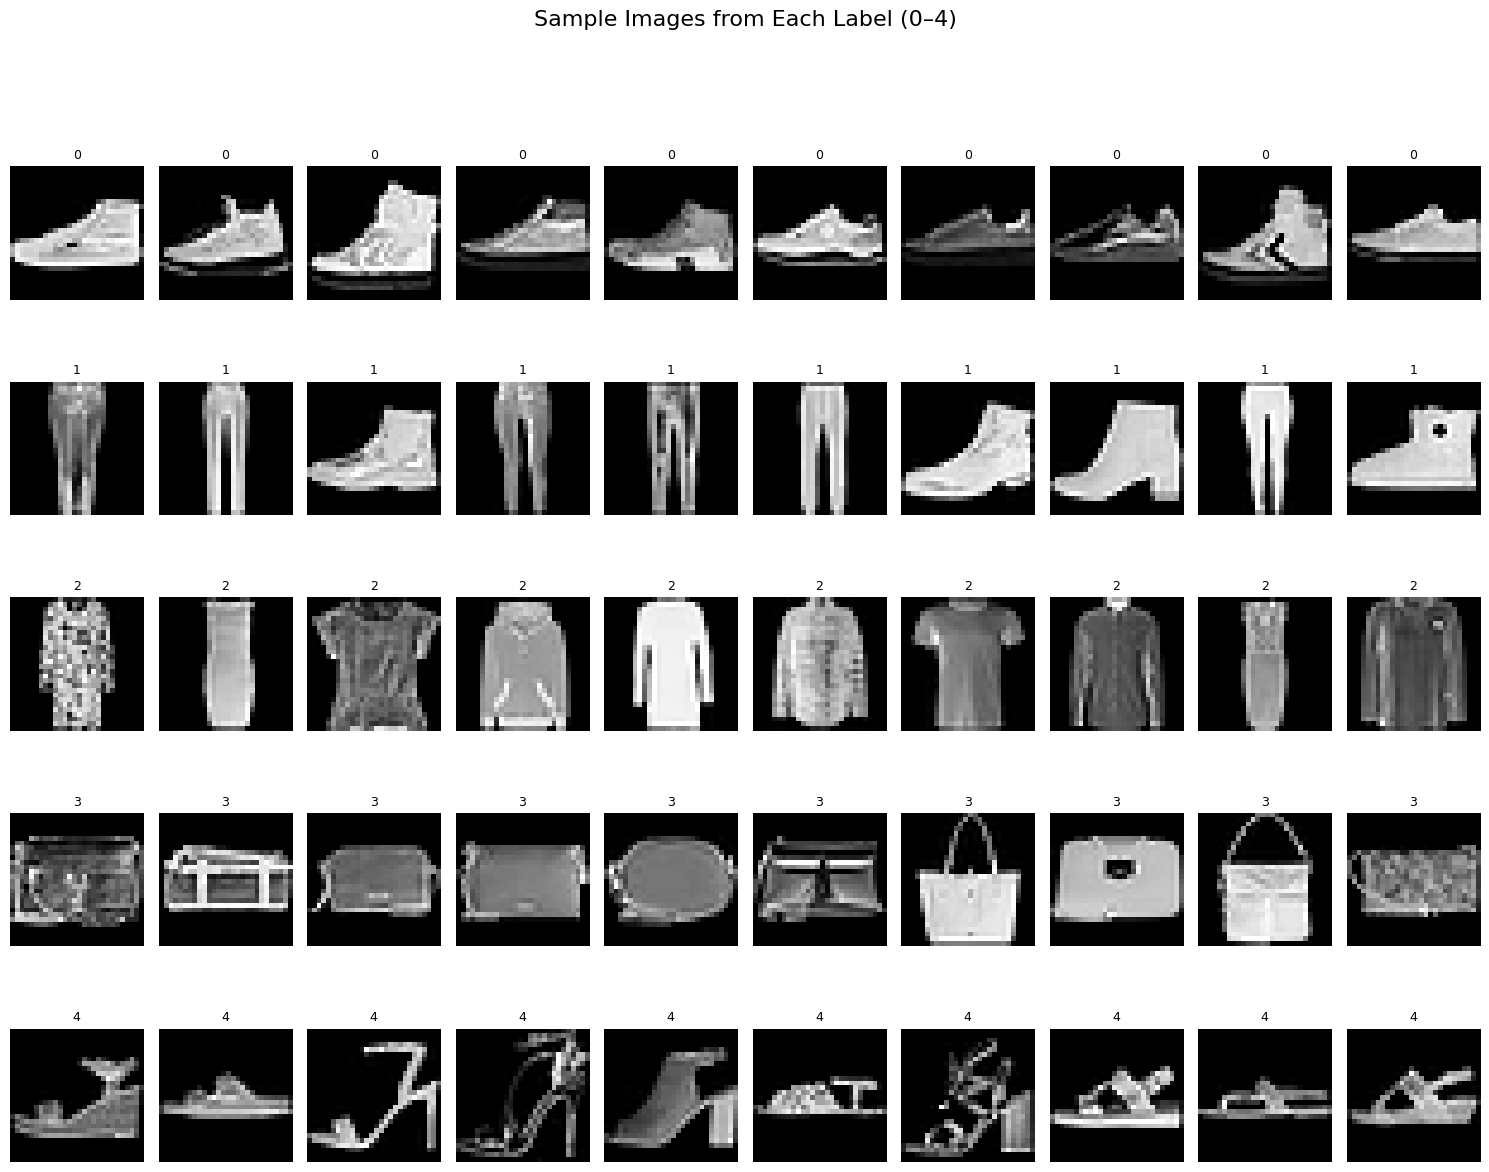

In [51]:
import matplotlib.pyplot as plt
import numpy as np

def show_label_samples(images_tensor, label_tensor, n_labels=5, samples_per_label=10):
    """
    Display sample images from each label group (0 to n_labels-1),
    with label annotations below each image.
    """
    images_np = images_tensor.squeeze().cpu().numpy()  # shape: (N, 28, 28)
    labels_np = label_tensor.cpu().numpy()             # shape: (N,)

    plt.figure(figsize=(samples_per_label * 1.5, n_labels * 2.5))

    for label in range(n_labels):
        indices = np.where(labels_np == label)[0]
        if len(indices) == 0:
            continue
        selected = np.random.choice(indices, size=min(samples_per_label, len(indices)), replace=False)

        for i, idx in enumerate(selected):
            plt_idx = label * samples_per_label + i + 1
            plt.subplot(n_labels, samples_per_label, plt_idx)
            plt.imshow(images_np[idx], cmap='gray')
            plt.axis('off')
            plt.title(f"{labels_np[idx]}", fontsize=9)

            if i == 0:
                plt.ylabel(f"Label {label}", fontsize=12)

    plt.suptitle("Sample Images from Each Label (0–4)", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    plt.show()


show_label_samples(x_test_tensor, y_test_tensor, n_labels=5, samples_per_label=10)

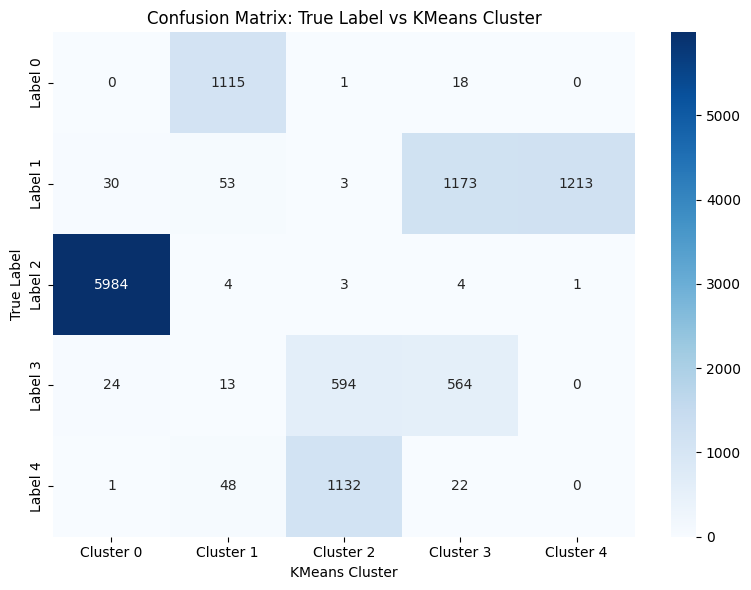

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd

# y_true: actual labels from dataset
y_true = features_df["label"].values

# y_pred: cluster labels assigned by KMeans
y_pred = cluster_labels

# Compute confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Create labeled DataFrame
conf_df = pd.DataFrame(conf_mat, 
                       index=[f"Label {i}" for i in range(5)], 
                       columns=[f"Cluster {i}" for i in range(5)])

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_df, annot=True, fmt='d', cmap='Blues', cbar=True)

plt.title("Confusion Matrix: True Label vs KMeans Cluster")
plt.xlabel("KMeans Cluster")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()